# Fit the complete data (With sWeights and without sWeights)
This file is fitting for different cuts on the BDT variable

- Fit on $m(B^0_s)$ with $m(3\pi)$ around $m(D_s)$ and sWeights
    - Signal $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ (gaussian)
    - Background of partially reconstructed decays (gaussian)
    - Combinatorial background (exponential)
- Fit on $m(B^0_s)$ with:
    - Signal $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ (sum of two Crystall ball PDF)
    - Background $B^0 \to D^{*-} D_s^+$ from the other fit of the simultaneous fit
    - Background with a misidentified pion: $B^0 \to D^{*-} K^+ \pi^+ \pi^-$ (sum of two crystall ball PDF)
    - Background of partially reconstructed decays $B^0 \to D^{*-} \pi^+ \pi^+ \pi^- h$ (gaussian)
    - Combinatorial background (exponential)

Those two fits are not simultaneous

## Import

In [1]:
import zfit
import json
import numpy as np

from math import sqrt

from bd2dst3pi.locations import loc
from bd2dst3pi.definitions import years, magnets

import sys
sys.path.append(loc.SCRIPTS)
import functions as fct
from fit import launch_fit, save_params, plot_hist_fit, plot_hist_fit_particle

Welcome to JupyROOT 6.22/02


## Load

In [2]:
# Mean of the distribution of the partially reconstructed data
with open(f'{loc.JSON}/data_strip_p/all_data_strip_params.json', 'r') as f:
    mu2_p = json.load(f)['mu2']


In [3]:
df_common = fct.load_data(years, magnets, type_data='common', vars=['B0_M', 'BDT'],
                            cut_DeltaM=True)

/afs/cern.ch/user/c/correian/bd2dst3pi/output/root/common/all_common.root


In [4]:
df_common_Ds = fct.load_data(years, magnets, type_data='common', vars=['B0_M', 'BDT', 'sWeight'],
                            cut_DeltaM=True, cut_tau_Ds=True)

/afs/cern.ch/user/c/correian/bd2dst3pi/output/root/common/common_B0toDstDs.root


In [5]:
name_data = 'common_cutDeltaM_V8_rFixed'
name_data_B0Ds = 'common_cutDeltaM_Ds_weighted_V8'

In [9]:
with open(f'{loc.JSON}/common_cutDeltaM_V8_fixedTails_params.json', 'r') as f:
    common_params = json.load(f)

sigm = common_params['sigmaR'],common_params['sigmaL'])
mea = common_params['mu']

FileNotFoundError: [Errno 2] No such file or directory: '/afs/cern.ch/user/c/correian/bd2dst3pi/output/json/common_cutDeltaM_V8_rFixed_fixedTails_params.json'

## cut on BDT

In [6]:
cut_BDT = -0.35
k = str(cut_BDT)

In [7]:
df = df_common.query(f"BDT > {cut_BDT}")

In [8]:
df_Ds = df_common_Ds.query(f"BDT > {cut_BDT}")

In [10]:
cut_BDT_ref = None

In [11]:
def format_previous_params(df_params_recup):
    df_params_recup_formatted = {}
    for key, value in df_params_recup.items():
        if not key.endswith('_err'):
            index = key.find('|')
            df_params_recup_formatted[key[:index]] = value
    
    return df_params_recup_formatted

In [23]:
if cut_BDT_ref is None:
    with open(f'{loc.JSON}/{name_data}_fixedTails_params.json', 'r') as f:
        params_r = json.load(f)
    with open(f'{loc.JSON}/{name_data_B0Ds}_params.json', 'r') as f:
        B0Ds_params_r = json.load(f)
    
else:
    with open(f'{loc.JSON}/{name_data}_BDT{cut_BDT_ref}_params.json', 'r') as f:
        params_recup = json.load(f)

    params_r = format_previous_params(params_recup)
    
    with open(f'{loc.JSON}/{name_data_B0Ds}_BDT{cut_BDT_ref}_params.json', 'r') as f:
        B0Ds_params_recup = json.load(f)
    
    B0Ds_params_r = format_previous_params(B0Ds_params_recup)

## Fit on weighted `B0_M` with `|tau_M-1969|<50`

### Data

In [24]:
size_tau_M = 50.
mean_tau_M = 1969.
low_tau_M = mean_tau_M - size_tau_M
high_tau_M = mean_tau_M + size_tau_M

In [25]:
low_B0Ds = 5150.
high_B0Ds = 5360.

### Distributions

/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/functions.py:619: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(counts)


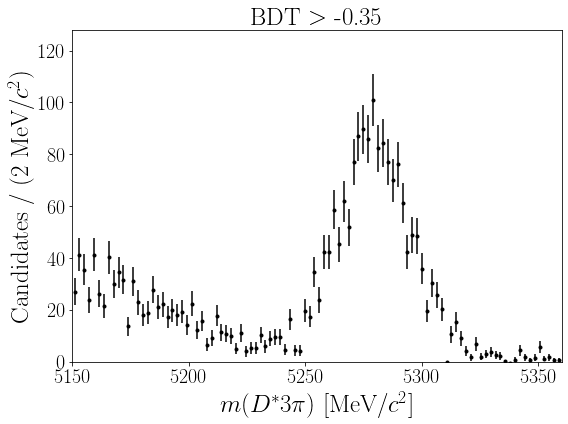

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/B0_M_all_data_strip_cutDeltaM_Ds_weighted_V8_BDT-0.35.pdf


In [26]:
fct.plot_hist_particle({name_data_B0Ds:df_Ds},'B0_M',
              low = low_B0Ds, high = high_B0Ds, cut_BDT = k,
              n_bins = 100, mode_hist = False, colors='black', weights=df_Ds['sWeight'])

### Intial values

In [27]:
n_events_B0Ds = len(df_Ds.query(f'B0_M > {low_B0Ds} and B0_M < {high_B0Ds}'))

n_sig_k = B0Ds_params_r['n_sig_B0Ds']
n_bkg_k = B0Ds_params_r['n_bkg_B0Ds']
n_bkg2_k = B0Ds_params_r['n_bkg2_B0Ds']

# for BDT = -2.0
initial_values_B0Ds = {
    # Signal
    'mu_B0Ds'       :{ 'value': B0Ds_params_r['mu_B0Ds']      , 'low': 5279.-4.       , 'high': 5279.+4.             , 'floating': True},
    'sigma_B0Ds'    :{ 'value': B0Ds_params_r['sigma_B0Ds']   , 'low': 15.-5.        , 'high': 15.+5.                , 'floating': True},
    'n_sig_B0Ds'    :{ 'value': n_sig_k                       , 'low': 0              , 'high': n_events_B0Ds        , 'floating': True},
    # Combinatorial background
    'lambda_B0Ds'   :{ 'value': B0Ds_params_r['lambda_B0Ds']  , 'low': -0.1           , 'high': -0.0000001           , 'floating': True},
    'n_bkg_B0Ds'    :{ 'value': n_bkg_k                       , 'low': 0              , 'high': n_events_B0Ds        , 'floating': True},
    # Partially reconstructed particles
    'mu2_B0Ds'      :{ 'value': mu2_p                         , 'low': 4800.          , 'high': 5150.                , 'floating': False},
    'sigma2_B0Ds'   :{ 'value': B0Ds_params_r['sigma2_B0Ds']  , 'low': 50.            , 'high': 90.                  , 'floating': True},
    'n_bkg2_B0Ds'   :{ 'value': n_bkg2_k                      , 'low': 0              , 'high': n_events_B0Ds        , 'floating': True},
}

### Observables and variables

In [28]:
obs_B0Ds = zfit.Space("x", limits=(low_B0Ds, high_B0Ds))

zparams_B0Ds = {}
for var in initial_values_B0Ds.keys():
    zparams_B0Ds[var] = zfit.Parameter(f"{var}|BDT{cut_BDT}",
                                      initial_values_B0Ds[var]['value'], 
                                      initial_values_B0Ds[var]['low'], 
                                      initial_values_B0Ds[var]['high'],
                                      floating = initial_values_B0Ds[var]['floating'])

In [29]:
name_params_B0Ds = {
    # Signal
    f'mu_B0Ds|BDT{cut_BDT}'      : '$\mu_S$',
    f'sigma_B0Ds|BDT{cut_BDT}'   : '$\\sigma_S$',
    f'n_sig_B0Ds|BDT{cut_BDT}'   : '$n_S$',
    # Combinatorial background
    f'n_bkg_B0Ds|BDT{cut_BDT}'   : '$n_{B,c}$',
    f'lambda_B0Ds|BDT{cut_BDT}'  : '$\\lambda_{B,c}$',
    # Partially reconstructed background
    f'mu2_B0Ds|BDT{cut_BDT}'     : '$\\mu_{B, D^*3 D_s h}$',
    f'sigma2_B0Ds|BDT{cut_BDT}'  : '$\\sigma_{B, D^* D_s h}$',
    f'n_bkg2_B0Ds|BDT{cut_BDT}'  : '$n_{B, D^* D_s h}$',
}

### PDFs

In [30]:
gaussianS_B0Ds = zfit.pdf.Gauss(zparams_B0Ds[f'mu_B0Ds'],zparams_B0Ds['sigma_B0Ds'],obs=obs_B0Ds)
exponential_B0Ds = zfit.pdf.Exponential(zparams_B0Ds['lambda_B0Ds'], obs=obs_B0Ds)
gaussian_B0Ds = zfit.pdf.Gauss(zparams_B0Ds['mu2_B0Ds'],zparams_B0Ds['sigma2_B0Ds'],obs=obs_B0Ds)

gaussianS_B0Ds_ext = gaussianS_B0Ds.create_extended(zparams_B0Ds['n_sig_B0Ds'])
exponential_B0Ds_ext = exponential_B0Ds.create_extended(zparams_B0Ds['n_bkg_B0Ds'])
gaussian_B0Ds_ext = gaussian_B0Ds.create_extended(zparams_B0Ds['n_bkg2_B0Ds'])

model_B0Ds = zfit.pdf.SumPDF([gaussianS_B0Ds_ext, exponential_B0Ds_ext, gaussian_B0Ds_ext])
data_B0Ds = zfit.Data.from_pandas(df_Ds['B0_M'], obs=obs_B0Ds, weights=df_Ds['sWeight'])

### Fitting

In [31]:
import timeit
start = timeit.default_timer()
result_B0Ds, params_B0Ds = launch_fit( model_B0Ds, data_B0Ds, extended=True)
result_B0Ds, params_B0Ds = launch_fit( model_B0Ds, data_B0Ds, extended=True)
stop = timeit.default_timer()
print('Time to do the fit: ', stop - start) 

------------------------------------------------------------------
| FCN = -4682                   |     Ncalls=236 (236 total)     |
| EDM = 0.000641 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------


/afs/cern.ch/work/c/correian/miniconda/envs/bd2dst3pi_env/lib/python3.7/site-packages/zfit/minimizers/fitresult.py:46: ExperimentalFeatureWarning: The computation of the covariance matrix with weights is still experimental.
  ExperimentalFeatureWarning)


name                      value    minuit_hesse    at limit
--------------------  ---------  --------------  ----------
n_sig_B0Ds|BDT-0.35        1530     +/-      42       False
n_bkg_B0Ds|BDT-0.35       166.6     +/-      54       False
n_bkg2_B0Ds|BDT-0.35      778.1     +/-      46       False
mu_B0Ds|BDT-0.35           5280     +/-    0.59       False
sigma_B0Ds|BDT-0.35       15.22     +/-    0.53       False
lambda_B0Ds|BDT-0.35  -1.31e-05     +/- 0.00024       False
sigma2_B0Ds|BDT-0.35      75.58     +/-     3.8       False
------------------------------------------------------------------
| FCN = -4682                   |      Ncalls=98 (98 total)      |
| EDM = 4.44e-05 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False 

/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/fit.py:560: UserWarning: The function <function Space.limits at 0x7fbad45524d0> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=None, limits=(array([[5150.]]), array([[5360.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  low = float(obs.limits[0])
/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/functions.py:619: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(counts)
/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/fit.py:37: UserWarning: The function <function Space.area at 0x7fbad45588c0> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=None, limits=(array([[5150.]]), array([[5360.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is i

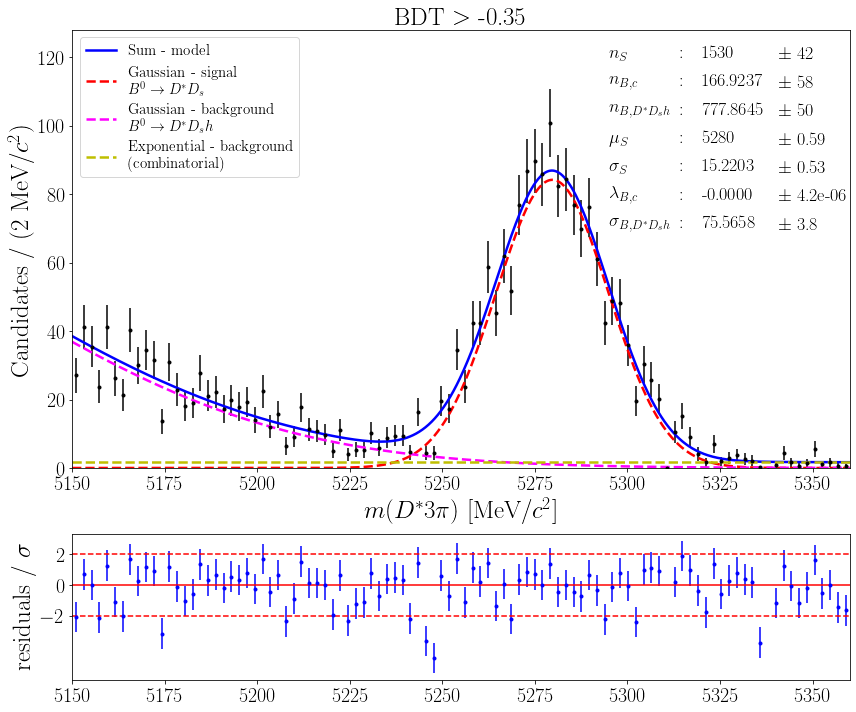

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/all_data_strip_cutDeltaM_V8/B0_M_all_data_strip_cutDeltaM_Ds_weighted_V8_fit_BDT-0.35.pdf


In [32]:
plot_hist_fit_particle(df_Ds,'B0_M', models = [model_B0Ds, gaussianS_B0Ds_ext, gaussian_B0Ds_ext, exponential_B0Ds_ext],
                       name_models = ["", '\n $B^0\\to D^*D_s$','\n $B^0\\to D^*D_s h$',
                                      '\n (combinatorial)'], cut_BDT=k,
                       obs=obs_B0Ds, n_bins = 100,mode_hist = False,
                       name_data = name_data_B0Ds, name_folder=name_data,
                       colors=['b','r','magenta','y'], weights=df_Ds['sWeight'],
                       params=params_B0Ds,name_params=name_params_B0Ds,
                       colWidths=[0.05,0.01,0.05,0.04],
                       fontsize_res = 18.,
                       fontsize_leg=15)

In [33]:
save_params(params_B0Ds, name_data_B0Ds+f'_BDT{cut_BDT}', True)

parameters saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/json/all_data_strip_cutDeltaM_Ds_weighted_V8_BDT-0.35_params.json


## Fit on the full `B0_M`

### Data

In [34]:
# Result of the fit on the MC D0S->D*pipipi data with one of the pi misidentified as a kaon
with open(f'{loc.JSON}/data_KPiPi_2_params.json', 'r') as f:
    data_KPiPi_params = json.load(f)

for var in 'muL', 'muR', 'sigmaL', 'sigmaR': # conversion GeV -> MeV
    data_KPiPi_params[var] = data_KPiPi_params[var]*1000
    data_KPiPi_params[f"{var}_err"] = data_KPiPi_params[f"{var}_err"]*1000    
    
# Result of the previous fit on the B0_M sWeighted distribution with cut on tau_M around m(Ds)
with open(f'{loc.JSON}/{name_data_B0Ds}_BDT{cut_BDT}_params.json', 'r') as f:
    data_B0Ds_params = json.load(f)


    
# Result of the fit on the MC signal data
with open(f'{loc.JSON}/MC_params.json', 'r') as f:
    MC_param_results = json.load(f)

In [35]:
low = 5150.
high = 5550.

### Distribution

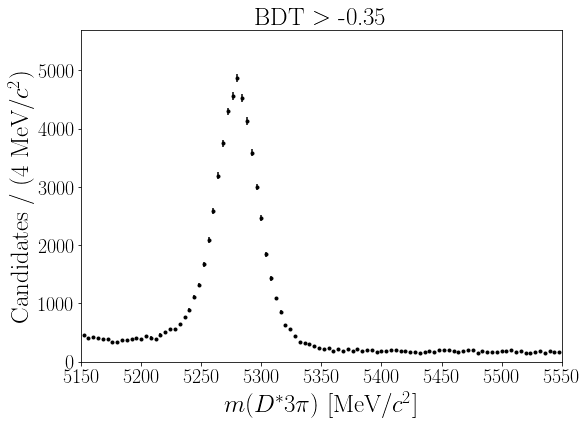

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/B0_M_all_data_strip_cutDeltaM_V8_BDT-0.35.pdf


In [36]:
fct.plot_hist_particle({name_data:df},'B0_M',
              low = low, high = high, cut_BDT=cut_BDT,
              n_bins = 100, mode_hist = False, colors='black')

### Initial values

In [37]:
n_events_B0_M = len(df.query(f'B0_M > {low} and B0_M < {high}'))

n_sig_k = params_r['n_sig']
n_bkg_k = params_r['n_bkg']
n_bkg2_k = params_r['n_bkg2']

initial_values = {
    # Signal        
    'mu'       :{ 'value': params_r['mu']                , 'low': 5279.-5.       , 'high': 5279.+5.             , 'floating': True},
    'sigmaL'   :{ 'value': params_r['sigmaL']            , 'low': 17.-15.        , 'high': 17.+15.              , 'floating': True},
    'sigmaR'   :{ 'value': params_r['sigmaR']            , 'low': 17.-15.        , 'high': 17+15.               , 'floating': True},
    'alphaL'   :{ 'value': MC_param_results['alphaL_MC'] , 'low': 0.1            , 'high': 10.                  , 'floating': False},
    'alphaR'   :{ 'value': -MC_param_results['alphaR_MC'], 'low': -10.            , 'high': -0.1                , 'floating': False},
    'nL'       :{ 'value': MC_param_results['nL_MC']     , 'low': 0.1            , 'high': 200.                 , 'floating': False},
    'nR'       :{ 'value': MC_param_results['nR_MC']     , 'low': 1.             , 'high': 200.                 , 'floating': False},
    'frac'     :{ 'value': params_r['frac']              , 'low': 0.1              , 'high': 1.                 , 'floating': True},
    'n_sig'    :{ 'value': n_sig_k                       , 'low': n_sig_k*0.5    , 'high': n_events_B0_M        , 'floating': True},
    # Combinatorial background        
    'lambda'   :{ 'value': params_r['lambda']            , 'low': -0.01          , 'high': -0.00001             , 'floating': True},
    'n_bkg'    :{ 'value': n_bkg_k                       , 'low': n_bkg_k*0.5    , 'high': n_events_B0_M        , 'floating': True},
    # Partially reconstructed particles        
    'mu2'      :{ 'value': mu2_p                         , 'low': 4800.          , 'high': 5150.                , 'floating': False},
    'sigma2'   :{ 'value': 80.                           , 'low': 10.            , 'high': 5150.-mu2_p          , 'floating': True},
    'n_bkg2'   :{ 'value': n_bkg2_k                      , 'low': 0              , 'high': n_events_B0_M        , 'floating': True},
    # Background decay D*Kpipi    
#     'n_bkgK'   :{ 'value': n_bkgK_k                      , 'low': 0              , 'high': n_events_B0_M        , 'floating': True},
    'r_bkgK'   :{ 'value': params_r['r_bkgK']            , 'low': 0.0001          , 'high': 0.5                   , 'floating': False},
}



for var in 'muL', 'muR', 'sigmaL', 'sigmaR', 'nL', 'nR', 'alphaL', 'alphaR', 'nL', 'nR', 'fraction':
    initial_values[f'{var}_K'] = {'value': data_KPiPi_params[var], 'low': None, 'high': None, 'floating': False}

for var in 'mu', 'sigma', 'n_sig' :
    initial_values[f'{var}_Ds'] = {'value': data_B0Ds_params[f'{var}_B0Ds|BDT{cut_BDT}'], 'low': None, 'high': None, 'floating': False}

In [38]:
print(params_r)

{'frac': 0.36597131077116174, 'frac_err': 0.04477506730478005, 'lambda': -0.0009777775211016401, 'lambda_err': 0.00013214752145974877, 'mu': 5279.670672196767, 'mu_err': 0.10997239662751408, 'n_bkg': 30227.08034829059, 'n_bkg2': 374.4189048511811, 'n_bkg2_err': 98.06063968504371, 'n_bkg_err': 487.8285911284329, 'n_sig': 51946.003209612085, 'n_sig_err': 389.070934645212, 'r_bkgK': 0.032785384091824694, 'r_bkgK_err': 0.007686768256103177, 'sigma2': 33.46084345188925, 'sigma2_err': 5.115606474058789, 'sigmaL': 12.927803255733908, 'sigmaL_err': 0.5385460815292429, 'sigmaR': 21.824391433321082, 'sigmaR_err': 0.37977894852605804}


### Observables and variables

In [39]:
obs = zfit.Space("x", limits=(low, high))

zparams = {}
for var in initial_values.keys():
    zparams[var] = zfit.Parameter(f"{var}|BDT{cut_BDT}",
                                  initial_values[var]['value'], 
                                  initial_values[var]['low'], 
                                  initial_values[var]['high'],
                                  floating = initial_values[var]['floating'])


mult = lambda r, n: r*n
zparams["n_bkgK"] = zfit.ComposedParameter(f"n_bkgK|BDT{cut_BDT}", mult, params=[zparams['r_bkgK'],zparams['n_sig']])

In [40]:
name_params = {
    # Signal
    f'mu|BDT{cut_BDT}'      : '$\mu_S$',
    f'sigmaL|BDT{cut_BDT}'  : '$\\sigma_{L_S}$',
    f'sigmaR|BDT{cut_BDT}'  : '$\\sigma_{R_S}$',    
    f'alphaL|BDT{cut_BDT}'  : '$\\alpha_{L_S}$',
    f'alphaR|BDT{cut_BDT}'  : '$\\alpha_{R_S}$',
    f'nL|BDT{cut_BDT}'      : '$n_L_S$',
    f'nR|BDT{cut_BDT}'      : '$n_R_S$',
    f'frac|BDT{cut_BDT}'    : '$f_{S, \\frac{L}{R}}$',
    f'n_sig|BDT{cut_BDT}'   : '$n_S$',
    # Combinatorial background
    f'n_bkg|BDT{cut_BDT}'   : '$n_{B,c}$',
    f'lambda|BDT{cut_BDT}'  : '$\\lambda_{B,c}$',
    # Partially reconstructed brackground
    f'mu2|BDT{cut_BDT}'     : '$\\mu_{B,D^*3\pi h}$',
    f'sigma2|BDT{cut_BDT}'  : '$\\sigma_{B,D^*3\pi h}$',
    f'n_bkg2|BDT{cut_BDT}'  : '$n_{B,D^*3\pi h}$',
    # Background decay D*Kpipi    
    f'n_bkgK|BDT{cut_BDT}'  : '$n_{B,D^*K\pi\pi}$',
    f'r_bkgK|BDT{cut_BDT}'  : '$\\frac{n_{B,D^*K\pi\pi}}{n_S}$',
}


### PDFs

In [41]:
def crystall_ball_gaussian(mu, sigma, obs, alpha=None, n=None):
    if alpha is None or n is None:
        pdf = zfit.pdf.Gauss(mu, sigma, obs=obs)
    else:
        pdf = zfit.pdf.CrystalBall(mu, sigma, alpha, n, obs=obs)
    return pdf

def sum_crystalball(muL, muR, sigmaL, sigmaR, frac, obs, alphaL=None, alphaR=None, nL=None, nR=None):
    """ Return the sum of 2 crystall ball PDFs.
    If the alpha or n is None, the corresponding distribution is a gaussian.
    """
    pdfL = crystall_ball_gaussian(muL, sigmaL, obs,
                                         alphaL,nL)
    pdfR = crystall_ball_gaussian(muR, sigmaR, obs,
                                         alphaR, nR)
    
    model = zfit.pdf.SumPDF([pdfL, pdfR], fracs=frac)
    
    return model, pdfL, pdfR

In [42]:
model_S, crystalBallL_S, crystalBallR_S = sum_crystalball(zparams['mu'], zparams['mu'],
                                                          zparams['sigmaL'], zparams['sigmaR'],
                                                          zparams['frac'], obs,                                                          
                                                          zparams['alphaL'], zparams['alphaR'], 
                                                          zparams['nL'], zparams['nR']
                                                         )


gaussian_B0Ds = zfit.pdf.Gauss(zparams['mu_Ds'],zparams['sigma_Ds'],obs=obs)

model_K, crystalBallL_K, crystalBallR_K = sum_crystalball(zparams['muL_K'], zparams['muR_K'], 
                                                          zparams['sigmaL_K'], zparams['sigmaR_K'],
                                                          zparams['fraction_K'], obs,
                                                          zparams['alphaL_K'], zparams['alphaR_K'], 
                                                          zparams['nL_K'], zparams['nR_K'])

exponential = zfit.pdf.Exponential(zparams['lambda'], obs=obs)
gaussian = zfit.pdf.Gauss(zparams['mu2'],zparams['sigma2'],obs=obs)


model_S_ext = model_S.create_extended(zparams['n_sig'])
exp_ext = exponential.create_extended(zparams['n_bkg'])
gaussian_ext = gaussian.create_extended(zparams['n_bkg2'])
gaussian_B0Ds_ext = gaussian_B0Ds.create_extended(zparams['n_sig_Ds'])
model_K_ext = model_K.create_extended(zparams['n_bkgK'])

model = zfit.pdf.SumPDF([model_S_ext, gaussian_B0Ds_ext, gaussian_ext, model_K_ext, exp_ext]) # gauss is folded by frac
data = zfit.Data.from_pandas(df['B0_M'], obs=obs)

### Fit

Sometimes I perform 2 fits so that the last one converges

In [43]:
import timeit
start = timeit.default_timer()
result, params = launch_fit(model, data, extended=True)
result, params = launch_fit(model, data, extended=True)
stop = timeit.default_timer()
print('Time to do the fit: ', stop - start) 

------------------------------------------------------------------
| FCN = -3.736e+05              |     Ncalls=639 (639 total)     |
| EDM = 0.000592 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
name                 value    minuit_hesse    at limit
---------------  ---------  --------------  ----------
n_sig|BDT-0.35       50790     +/- 4.2e+02       False
n_bkg2|BDT-0.35      372.2     

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


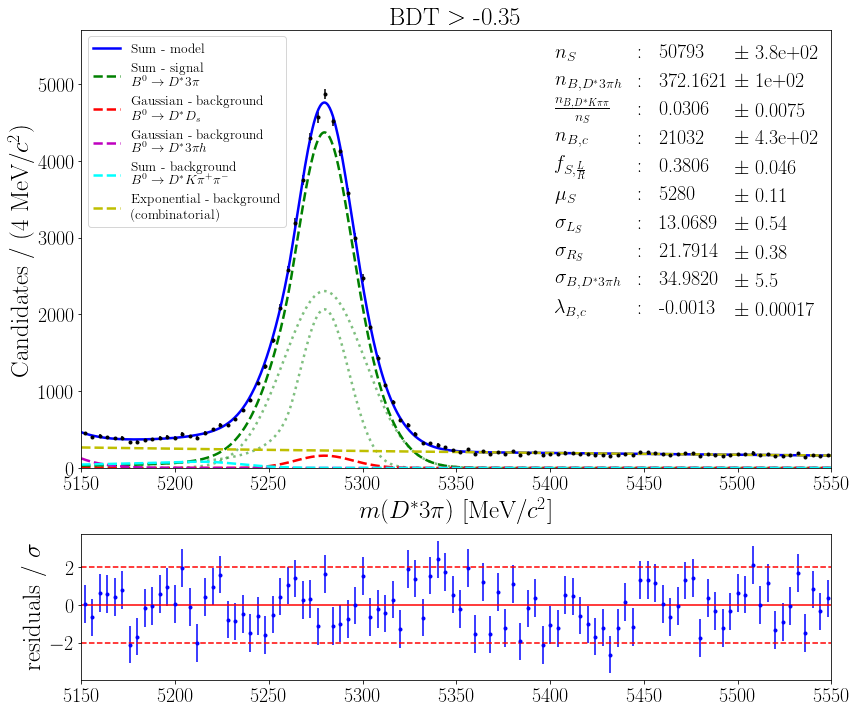

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/all_data_strip_cutDeltaM_V8/B0_M_all_data_strip_cutDeltaM_V8_detail_fit_BDT-0.35.pdf


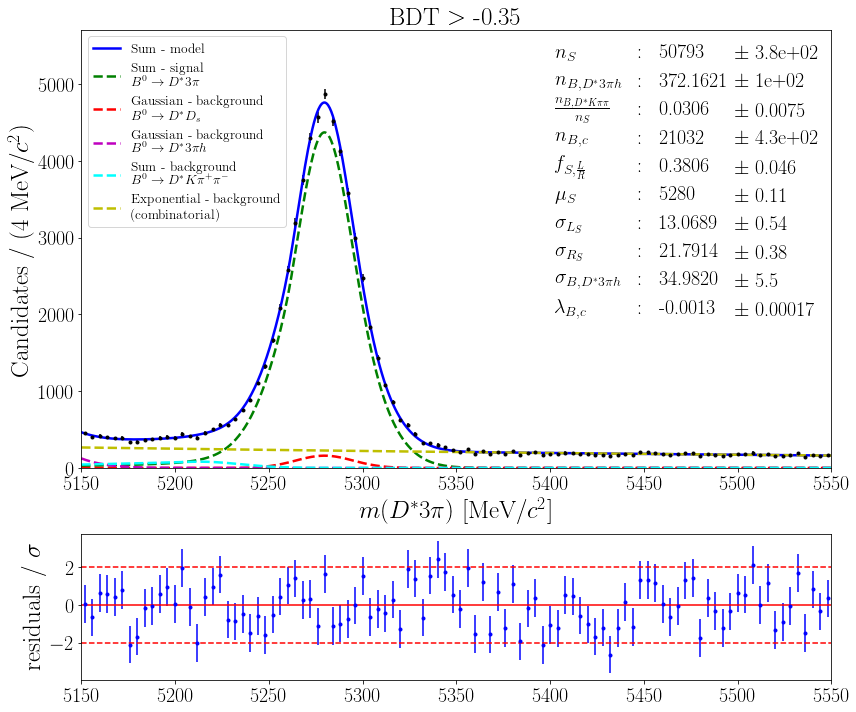

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/all_data_strip_cutDeltaM_V8/B0_M_all_data_strip_cutDeltaM_V8_fit_BDT-0.35.pdf


In [44]:
name_data_plot = name_data + '_detail'
plot_hist_fit_particle(df,'B0_M', models = [model,[model_S_ext, crystalBallL_S, crystalBallR_S], gaussian_B0Ds_ext, gaussian_ext, model_K_ext,exp_ext],
                       name_models = ["", '\n $B^0\\to D^* 3\pi$','\n $B^0\\to D^*D_s$','\n $B^0\\to D^*3\pi h$',
                                      '\n $B^0\\to D^* K \pi^+\pi^-$','\n (combinatorial)'],
                       cut_BDT=cut_BDT,
                       obs=obs, n_bins = 100,mode_hist = False,
                       name_data = name_data_plot, name_folder=name_data,
                       colors=['b','g','r','m','cyan','y'],
                       params=params,name_params=name_params,
                       fontsize_leg=13.5,
                       colWidths=[0.06,0.01,0.05,0.06]
                      )
name_data_plot = name_data
plot_hist_fit_particle(df,'B0_M', models = [model,model_S_ext, gaussian_B0Ds_ext, gaussian_ext, model_K_ext,exp_ext],
                       name_models = ["", '\n $B^0\\to D^* 3\pi$','\n $B^0\\to D^*D_s$','\n $B^0\\to D^*3\pi h$',
                                      '\n $B^0\\to D^* K \pi^+\pi^-$','\n (combinatorial)'],
                       cut_BDT=cut_BDT,
                       obs=obs, n_bins = 100,mode_hist = False,
                       name_data = name_data_plot, name_folder=name_data,
                       colors=['b','g','r','m','cyan','y'],
                       params=params,name_params=name_params,
                       fontsize_leg=13.5,
                       colWidths=[0.06,0.01,0.05,0.06]
                      )

In [45]:
integral = float(exp_ext.analytic_integrate([mea-3*sigm, mea+3*sigm]))
n_bkg = float(zparams['n_bkg'].value())
n_bkg_err = params[zparams['n_bkg']]['minuit_hesse']['error']
n_B = integral * n_bkg
n_B_err = integral * n_bkg_err

In [46]:
save_params(params,name_data + f"_BDT{cut_BDT}", True, {'n_B':n_B, 'n_B_err':n_B_err})

parameters saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/json/all_data_strip_cutDeltaM_V8_BDT-0.35_params.json
